<a href="https://colab.research.google.com/github/Muhirwakyeyune/AMMI-NATURAL-LANGUAGE-PROCESSING/blob/main/Muhirwa_Salomon_Fine_tune_a_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [2]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS. Uncomment the following instructions:

In [4]:
 !apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [5]:
import transformers

print(transformers.__version__)

4.30.2


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/language-modeling).

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [6]:
from transformers.utils import send_example_telemetry

send_example_telemetry("language_modeling_notebook", framework="pytorch")

# Fine-tuning a language model

In this notebook, we'll see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model on a language modeling tasks. We will cover two types of language modeling tasks which are:

- Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.

![Widget inference representing the causal language modeling task](https://github.com/huggingface/notebooks/blob/main/examples/images/causal_language_modeling.png?raw=1)

- Masked language modeling: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

![Widget inference representing the masked language modeling task](https://github.com/huggingface/notebooks/blob/main/examples/images/masked_language_modeling.png?raw=1)

We will see how to easily load and preprocess the dataset for each one of those tasks, and how to use the `Trainer` API to fine-tune a model on it.

A script version of this notebook you can directly run on a distributed environment or on TPU is available in our [examples folder](https://github.com/huggingface/transformers/tree/master/examples).

## Preparing the dataset

For each of those tasks, we will use the [Wikitext 2]() dataset as an example. You can load it very easily with the 🤗 Datasets library.

In [7]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

You can replace the dataset above with any dataset hosted on [the hub](https://huggingface.co/datasets) or use your own files. Just uncomment the following cell and replace the paths with values that will lead to your files:

In [8]:
# datasets = load_dataset("text", data_files={"train": path_to_train.txt, "validation": path_to_validation.txt}

You can also load datasets from a csv or a JSON file, see the [full documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) for more information.

To access an actual element, you need to select a split first, then give an index:

In [9]:
datasets["train"][41]

{'text': ''}

In [10]:
len("text")

4

In [11]:
datasets["train"]

Dataset({
    features: ['text'],
    num_rows: 36718
})

In [12]:
length_sequence = [len(i) for i in datasets["train"]["text"]]
print("length_sequence:", length_sequence)

length_sequence: [0, 30, 0, 706, 524, 574, 0, 19, 0, 1221, 1623, 496, 0, 15, 0, 1059, 1229, 1097, 0, 22, 0, 1512, 1433, 0, 20, 0, 1658, 0, 22, 0, 1421, 497, 0, 20, 0, 316, 736, 857, 500, 0, 17, 0, 374, 0, 26, 0, 1037, 1189, 658, 0, 0, 48, 0, 548, 503, 0, 23, 0, 1121, 0, 20, 0, 1584, 494, 46, 981, 755, 265, 87, 131, 121, 391, 479, 303, 40, 48, 46, 38, 26, 43, 20, 23, 41, 19, 944, 445, 346, 1082, 929, 690, 652, 418, 366, 274, 97, 49, 44, 18, 43, 39, 30, 13, 74, 55, 22, 97, 25, 18, 14, 39, 504, 625, 191, 113, 0, 26, 0, 661, 829, 0, 24, 0, 597, 355, 0, 21, 0, 952, 246, 658, 618, 0, 0, 25, 0, 507, 442, 458, 0, 20, 0, 0, 25, 0, 418, 410, 0, 56, 0, 242, 430, 428, 0, 50, 0, 437, 455, 0, 27, 0, 533, 985, 0, 27, 0, 216, 414, 687, 0, 35, 0, 401, 329, 0, 14, 0, 393, 471, 385, 0, 37, 0, 1167, 0, 41, 0, 700, 1135, 0, 16, 0, 0, 20, 0, 56, 80, 56, 57, 44, 39, 78, 61, 61, 44, 0, 20, 0, 48, 43, 48, 77, 48, 43, 50, 43, 44, 63, 95, 48, 38, 43, 47, 82, 55, 48, 47, 53, 75, 48, 74, 49, 59, 36, 49, 36, 36, 49

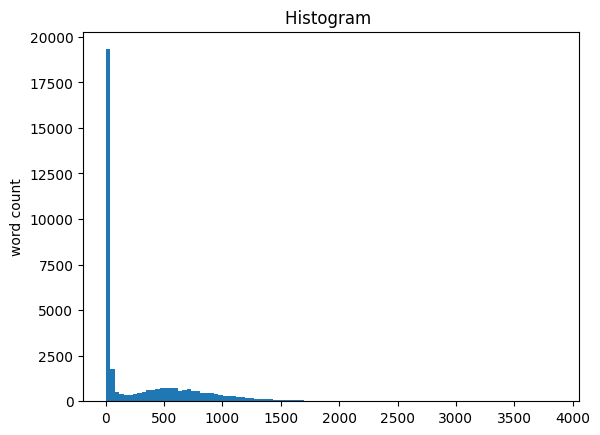

In [13]:
import matplotlib.pyplot as plt
plt.hist(length_sequence , bins=100)
plt.title("Histogram ")
plt.ylabel("word count")
plt.show()

In [14]:
import numpy as np
print(f"Mean value {np.mean(length_sequence )}, Standard deviation {np.std(length_sequence )}")

Mean value 296.6662127566861, Standard deviation 413.4041548373277


In [15]:
count=0
count1=0
for i in length_sequence  :
  count1+=1
  if i==0:
    count+=1
print(f"Proportion {(count/count1)*100}")

Proportion 35.27152895037856


To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [16]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [17]:

show_random_elements(datasets["train"])

,text
0,
1,"The interiors of each wing have separate uses . In the west wing is the baptistry , in the north is the main altar , the main entrance and a notary area , separated by inside corner walls made of chiluca stone and tezontle . Chiluca , a white stone , covers the walls and floors and the tezontle frames the doors and windows . At the crossing of the structure is an octagonal dome framed by arches that form curved triangles where they meet at the top of the dome . The principal altar is in the ornate Churrigueresque style and crafted by indigenous artist Pedro Patiño Ixtolinque . It was inaugurated in 1829 . \n"
2,= = = Recognition = = = \n
3,"Filming started on September 23 , 2004 , and concentrated on Enterprise ship scenes on the standing sets for the first two days . After that production moved to the cave sets , which were dressed with Vulcan artifacts . On the fourth day of production , those artifacts were removed so that the same sets could use used to film the visions that Archer has of Surak . All exterior scenes in the Vulcan desert @-@ like Forge were shot on a soundstage . The final day of filming took place on October 1 , when all the scenes set in the Vulcan High Command were filmed . These involved only Foxworth , Graham and Rubinstein as well as a handful of extras . \n"
4,
5,= = = Enzymes = = = \n
6,= = History = = \n
7,""" President Evil "" is the fifth episode of the third season of the American mystery television series Veronica Mars , and the forty @-@ ninth episode overall . Written by Jonathan Moskin and David Mulei and directed by Nick Marck , the episode premiered on The CW on October 31 , 2006 . \n"
8,"Two tramps , named Dusty and Weary , awake from their slumber in a hay stock and are overcome with thirst . The two drink from a horse trough and Dusty complains of toothache . The two go to the dentist office only to be kicked out . When the dentist departs on a cruise the two tramps then pose as dentists and occupy the office and pull teeth with pincers and tongs . When the rightful owners return they drive off again . The tramps continue in their venture and quickly make a large sum of money before they desire their old way of life . The two tramps then surrender the office to its rightful owners . \n"
9,"Gerard agreed to a compromise on the matter of obedience to Anselm . King Henry proposed that Anselm accept a witnessed oath from Gerard that he would remain bound by the profession he made to Anselm on his consecration as Bishop of Hereford . Gerard made this oath at the Council of Westminster in 1107 . It was a victory for Canterbury , but not a complete one , as Gerard avoided making a written profession , and it was specific to Gerard , not to his office . Gerard continued to oppose Anselm 's attempts to assert Canterbury 's primacy , but the two were reconciled before Gerard 's death . \n"


As we can see, some of the texts are a full paragraph of a Wikipedia article while others are just titles or empty lines.

## Causal Language modeling

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`distilgpt2`](https://huggingface.co/distilgpt2) model for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead:

In [ ]:
model_checkpoint = "distilgpt2"

To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the `AutoTokenizer` class:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our `datasets` object, using `batched=True` and 4 processes to speed up the preprocessing. We won't need the `text` column afterward, so we discard it.

In [ ]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

If we now look at an element of our datasets, we will see the text have been replaced by the `input_ids` the model will need:

In [ ]:
tokenized_datasets["train"]["input_ids"][1]

[796, 569, 18354, 7496, 17740, 6711, 796, 220, 198]

In [ ]:
tokens = [len(i) for i in tokenized_datasets["train"]["input_ids"]]
average_length = np.mean(tokens)
print("Average length of tokens:", average_length)

Average length of tokens: 65.14200119832235


Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. To do this, we will use the `map` method again, with the option `batched=True`. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [ ]:
# block_size = tokenizer.model_max_length
block_size = 128

Then we write the preprocessing function that will group our texts:

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the `map` method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of `block_size` every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

And we can check our datasets have changed: now the samples contain chunks of `block_size` contiguous tokens, potentially spanning over several of our original texts.

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' game and follows the " Nameless ", a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven ". \n The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries, along with Valkyria Chronicles II director Takeshi Oz'

Now that the data has been cleaned, we're ready to instantiate our `Trainer`. We will a model:

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

And some `TrainingArguments`:

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
!pip install accelerate -U
!pip install transformers[torch]
!pip install accelerate>=0.20.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import accelerate

In [ ]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
)

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/gpt-finetuned-wikitext2"` or `"huggingface/gpt-finetuned-wikitext2"`).

We pass along all of those to the `Trainer` class:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

And we can train our model:

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Once the training is completed, we can evaluate our model and get its perplexity on the validation set like this:

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("sgugger/my-awesome-model")
```

## Masked language modeling

For masked language modeling (MLM) we are going to use the same preprocessing as before for our dataset with one additional step: we will randomly mask some tokens (by replacing them by `[MASK]`) and the labels will be adjusted to only include the masked tokens (we don't have to predict the non-masked tokens).

We will use the [`distilroberta-base`](https://huggingface.co/distilroberta-base) model for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=masked-lm) instead:

In [ ]:
model_checkpoint = "distilroberta-base"

We can apply the same tokenization function as before, we just need to update our tokenizer to use the checkpoint we just picked:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

And like before, we group texts together and chunk them in samples of length `block_size`. You can skip that step if your dataset is composed of individual sentences.

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

The rest is very similar to what we had, with two exceptions. First we use a model suitable for masked LM:

In [ ]:
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

We redefine our `TrainingArguments`:

In [ ]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
)

Like before, the last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-wikitext2"` or `"huggingface/bert-finetuned-wikitext2"`).

Finally, we use a special `data_collator`. The `data_collator` is a function that is responsible of taking the samples and batching them in tensors. In the previous example, we had nothing special to do, so we just used the default for this argument. Here we want to do the random-masking. We could do it as a pre-processing step (like the tokenization) but then the tokens would always be masked the same way at each epoch. By doing this step inside the `data_collator`, we ensure this random masking is done in a new way each time we go over the data.

To do this masking for us, the library provides a `DataCollatorForLanguageModeling`. We can adjust the probability of the masking:

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

Then we just have to pass everything to `Trainer` and begin training:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

In [ ]:
trainer.train()

Like before, we can evaluate our model on the validation set. The perplexity is much lower than for the CLM objective because for the MLM objective, we only have to make predictions for the masked tokens (which represent 15% of the total here) while having access to the rest of the tokens. It's thus an easier task for the model.

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("sgugger/my-awesome-model")
```

In [ ]:
from transformers import pipeline, set_seed

set_seed(32)
generator = pipeline('text-generation', model="facebook/opt-125m", do_sample=True)
generator("What is the capital of Senegal ?")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'generated_text': 'What is the capital of Senegal ?\nCape Verde.\nCan confirm, there are almost'}]

In [ ]:
from transformers import pipeline

generator = pipeline('text-generation', model="facebook/opt-iml-1.3b")

generator("What is the capital of Senegal ?")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'What is the capital of Senegal ?\n Dakar'}]

In [ ]:
few_shot_samples = """
Input: Senegal
Output: Africa
Input: Sudan
Output: Africa
Input: United States
Output: America
Input: Australia
Output: Oceania
""".strip("\n")

new_sample = """
Input: France
Output:
""".strip("\n")

prompt = f"{few_shot_samples}\n{new_sample}"
prompt_size = len(generator.tokenizer(prompt)["input_ids"])
[result] = generator(prompt, max_length=prompt_size + 20)
print(result["generated_text"])

Input: Senegal
Output: Africa
Input: Sudan
Output: Africa
Input: United States
Output: America
Input: Australia
Output: Oceania
Input: France
Output: France
Input: Australia
Input: Canada
Input: United States
Input: Australia
Input:
